In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation
from scipy.interpolate import RegularGridInterpolator

SPEC_PIPE_LOC = "{}/JPL/W12_Drops/spec_paper/Spec_pipeline".format(os.path.expanduser("~"))
sys.path.append(SPEC_PIPE_LOC)
os.environ['SPEC_PIPE_LOC'] = SPEC_PIPE_LOC
from Spec_pipeline import SDSS_Spec, GMOS_Spec, DBSP_Spec

sys.path.append("Gas_and_dust/")
from draine_dust import draine_dust

sys.path.append("Gas_and_dust/fullspec_dust_models/")
from polWave import PolWave

from polWave_gas import PolWave_gas

In [2]:
#Measured polarizations. 
pol_data = dict()

# wid = 'W0116-0505'
# pol_data[wid] = dict()
# pol_data[wid]['bands'] = ['v', 'R', 'I']
# pol_data[wid]['pfrac'] = [0.0973, 0.109, 0.147]
# pol_data[wid]['host_frac'] = [1.0, 1.0, 1.0]
# pol_data[wid]['z'] = 3.173
# pol_data[wid]['spec'] = SDSS_Spec(wid, pol_data[wid]['z'], "spec-7046-56568-0425.fits")

wid = 'W0019-1046'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.064]
pol_data[wid]['host_frac'] = [0.70]
pol_data[wid]['z'] = 1.641
pol_data[wid]['spec'] = DBSP_Spec(wid, pol_data[wid]['z'], "w0019m1046_b.f.fits", blue=True)

wid = 'W0220+0137'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.129]
pol_data[wid]['host_frac'] = [0.83]
pol_data[wid]['z'] = 3.122
pol_data[wid]['spec'] = SDSS_Spec(wid, pol_data[wid]['z'], "spec-4267-55484-0056.fits")

wid = 'W0204-0506'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.253]
pol_data[wid]['host_frac'] = [0.96]
pol_data[wid]['z'] = 2.100
pol_data[wid]['spec'] = GMOS_Spec(wid, pol_data[wid]['z'], "W0204m0506.f.fits", inst_conf={"grating":"B600", "detector":"EEV", "slit_width":1.5})

wid = 'W0831+0140'
pol_data[wid] = dict()
pol_data[wid]['bands'] = ['R']
pol_data[wid]['pfrac'] = [0.069]
pol_data[wid]['host_frac'] = [1.0]
pol_data[wid]['z'] = 3.913
pol_data[wid]['spec'] = GMOS_Spec(wid, pol_data[wid]['z'], "W0831p0140.f.fits",inst_conf={"grating":"B600", "detector":"EEV", "slit_width":1.5})

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


In [3]:
#Load the bands.
def load_bands(band_names):

    #Load the filters.
    R_spec = np.loadtxt("M_SPECIAL_R.txt")
    I_bess = np.loadtxt("M_BESS_I.txt")
    v_high = np.loadtxt("v_HIGH.txt", skiprows=2)

    R_spec = R_spec[R_spec[:,1]>0.01]
    I_bess = I_bess[I_bess[:,1]>0.01]
    v_high = v_high[v_high[:,1]>0.01]

    #Transform the wavelengths to angstroms.
    R_spec[:,0] *= 10
    I_bess[:,0] *= 10
    v_high[:,0] *= 10

    v_high = v_high[(v_high[:,0]>4000.) & (v_high[:,0]<8000.)]
    I_bess = I_bess[(I_bess[:,0]>4000.) & (I_bess[:,0]<8000.)]
    R_spec = R_spec[(R_spec[:,0]>4000.) & (R_spec[:,0]<8000.)]

    Rbp= SpectralElement(Empirical1D, points=R_spec[:,0], lookup_table=R_spec[:,1]/100., keep_neg=False)
    Ibp= SpectralElement(Empirical1D, points=I_bess[:,0], lookup_table=I_bess[:,1]/100., keep_neg=False)
    vbp= SpectralElement(Empirical1D, points=v_high[:,0], lookup_table=v_high[:,1]/100., keep_neg=False)

    output_list = []
    for band_name in band_names:
        if band_name=="v":
            output_list.append(vbp)
        elif band_name=="R":
            output_list.append(Rbp)
        elif band_name=="I":
            output_list.append(Ibp)
        else:
            print("Incorrect band name: ", band_name)

    return [vbp, Rbp, Ibp]

In [4]:
def get_p_bb(dust_type, theta_angles, psi_angles, spec, bands, fw=True, bw=True):

    full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

    p_bb = np.zeros((len(bands), len(theta_angles), len(psi_angles)))

    if dust_type=="gas":
        model = PolWave_gas(fw=fw,bw=bw)
        for iband in range(len(bands)):
            for jtheta, theta in enumerate(theta_angles):
                th_aux = theta*np.ones(len(psi_angles))
                p_bb[iband, jtheta] = model.p((th_aux, psi_angles))

    else:
        model = PolWave(dust_type, folder="Gas_and_dust/fullspec_dust_models/", fw=fw, bw=bw)

        for iband, band in enumerate(bands):
            obs_I = Observation(full_spec, band, force='extrap')
            Ibb = obs_I.effstim(flux_unit='flam').value
            for jtheta, theta in enumerate(theta_angles):
                for kpsi, psi in enumerate(psi_angles):
                    th_aux = theta*np.ones(len(spec.lam_obs))
                    psi_aux = psi*np.ones(len(spec.lam_obs))
                    p_lam = model.p((spec.lam_rest.to(u.AA).value, th_aux, psi_aux))
            
                    Q_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam * p_lam, keep_neg=True)

                    obs_Q = Observation(Q_spec, band, force='extrap')
                    Qbb = obs_Q.effstim(flux_unit='flam').value
                    
                    p_bb[iband, jtheta, kpsi] = Qbb/Ibb
    return p_bb
    

In [5]:
def plot_pol(p_bb, theta_angles, psi_angles, ymax=1.02, plot_fname=None, plot_label=None, ax=None, fig=None):

    #Create the figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(12,9))

    #Set the normalization for the color map. 
    #Norm = mpl.colors.LogNorm(vmin=theta_s_angles[0], vmax=theta_s_angles[-1])
    Norm = mpl.colors.Normalize(vmin=theta_angles[0], vmax=theta_angles[-1])

    #Set the color map
    cmap = mpl.cm.jet

    #Run through every inclination angle plotting the curves.
    for jtheta, theta in enumerate(theta_angles):
        #Set the color
        c = cmap(Norm(theta))
        #Plot
        im = ax.plot(psi_angles, p_bb[jtheta], color=c, linestyle='solid')

    #Set the ticks to point inwards.
    ax.tick_params(axis='both', direction='in', labelsize=14, top=True, right=True)

    #Draw a colorbar. 
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=Norm, cmap=cmap), ax=ax, pad=0.01, aspect=30)
    #cb.set_label(label=r'Inclination Angle $\theta_S$ (deg)', fontsize=20)
    cb.set_label(label=r'Inclination Angle $\eta$ (deg)', fontsize=20)
    cb.ax.tick_params(labelsize=14) 

    #Set the axes limits.
    ax.set_xlim([0, np.max(psi_angles)])
    ax.set_ylim([0, ymax])

    #Set the axes labels.
    ax.set_ylabel('Degree of Polarization', fontsize=20)
    ax.set_xlabel(r'Opening Half-Angle $\psi$ (deg)', fontsize=20)

    #Set the main label in the top right corner. 
    if plot_label is not None:
        ax.text(0.98, 0.9, plot_label, va='center', ha='right', transform=ax.transAxes, fontsize=26)

    #Show the plot.
    if plot_fname is not None:
        plt.savefig(plot_fname, dpi=300, bbox_inches='tight')
    else:
        #plt.show()
        pass

In [6]:
theta_angles = np.arange(0., 90., 5.)
psi_angles = np.arange(0., 90., 5.)

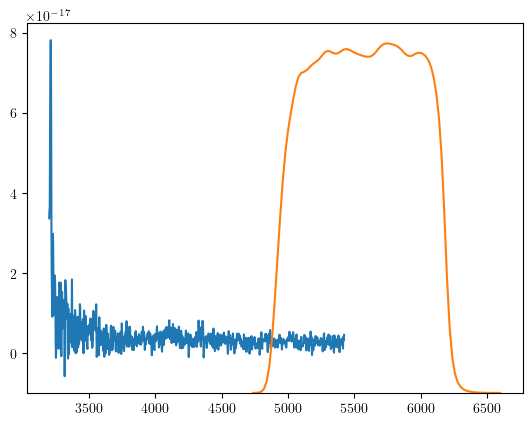

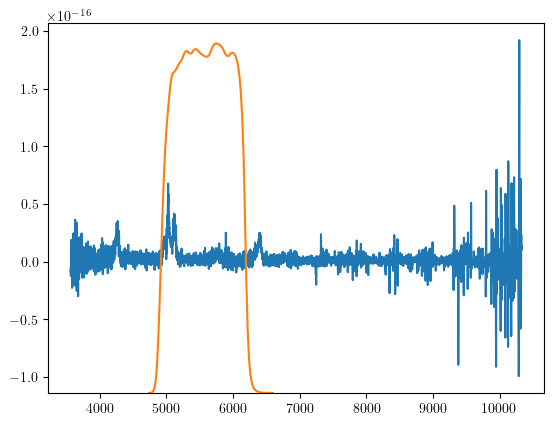

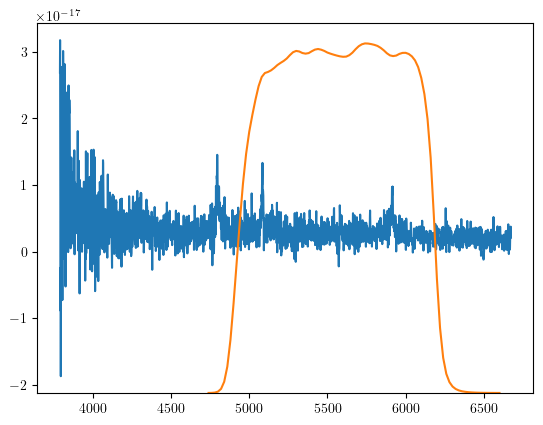

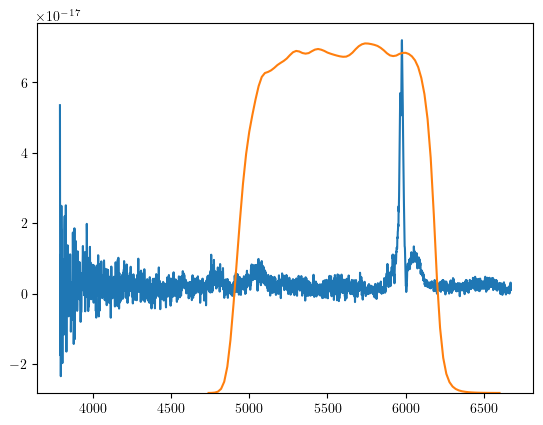

In [7]:
import matplotlib.transforms as transforms

#wid = "W0019-1046"
for wid in pol_data.keys():
    bands = load_bands(pol_data[wid]['bands'])

    spec = pol_data[wid]['spec']

    full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

    fig, ax = plt.subplots(1)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.plot(spec.lam_obs, spec.flam)
    ax.plot(bands[0]._model.points[0], bands[0]._model.lookup_table, transform=trans)
    plt.show()


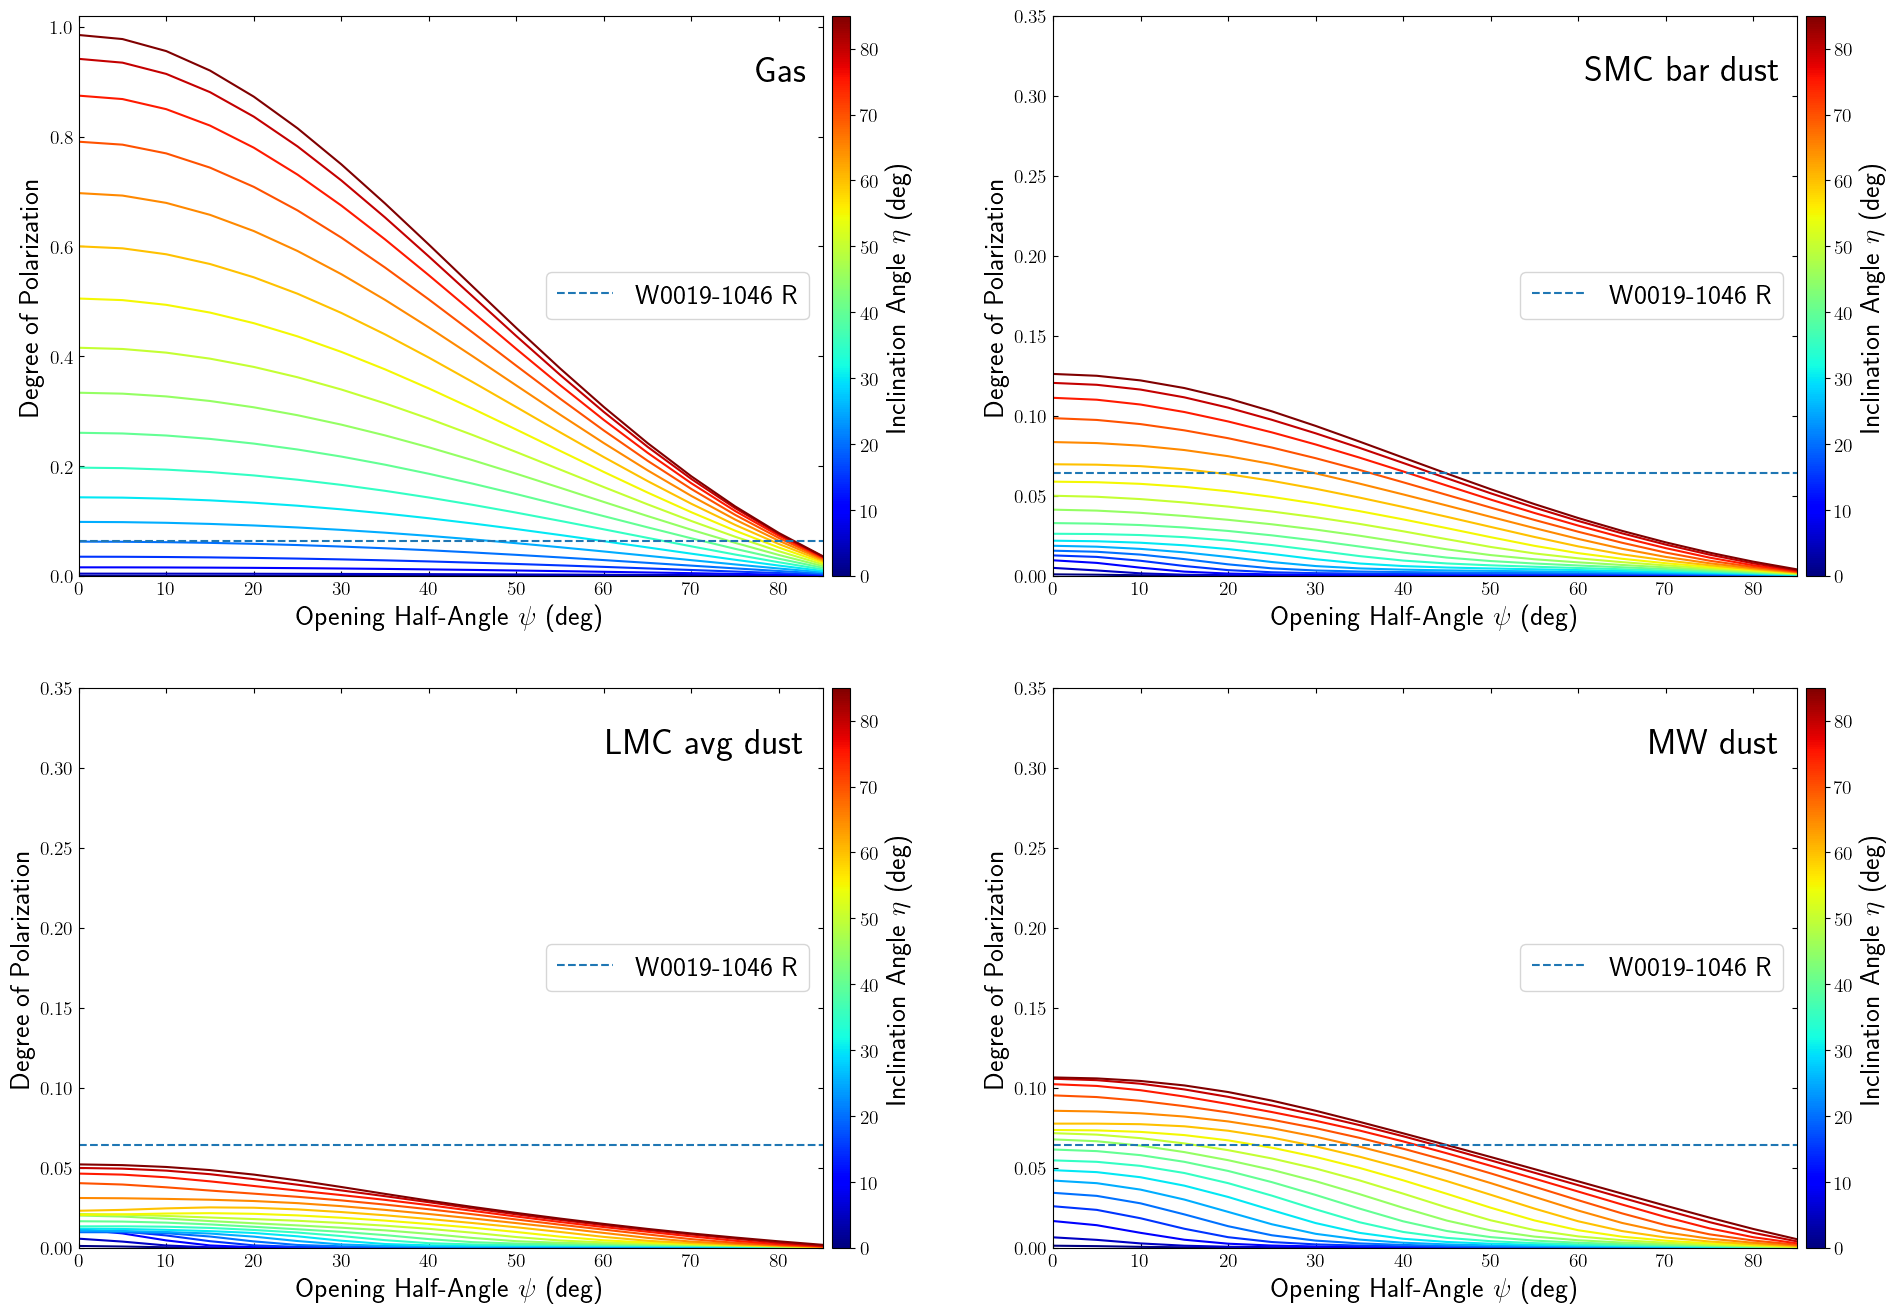

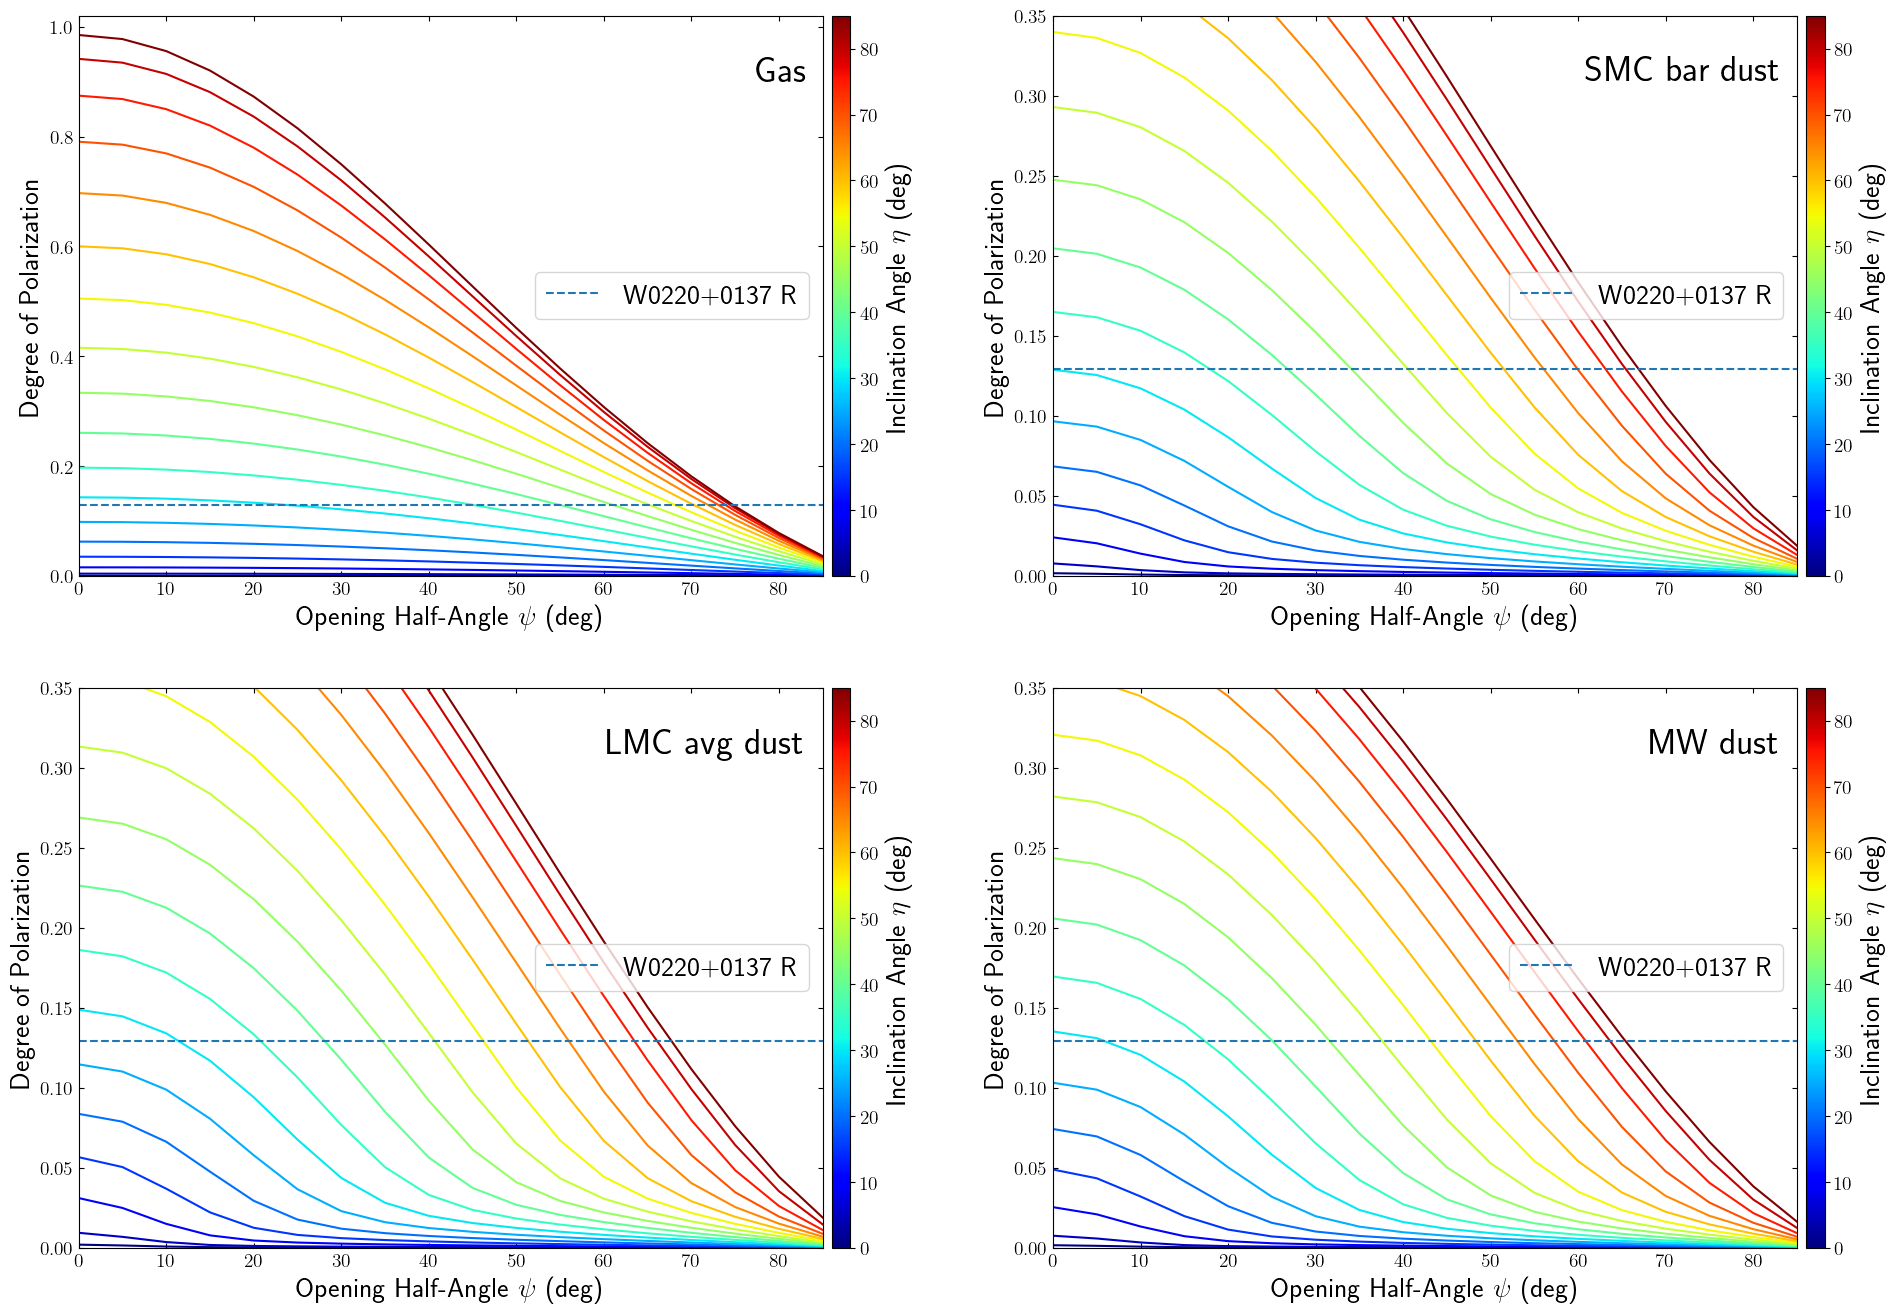

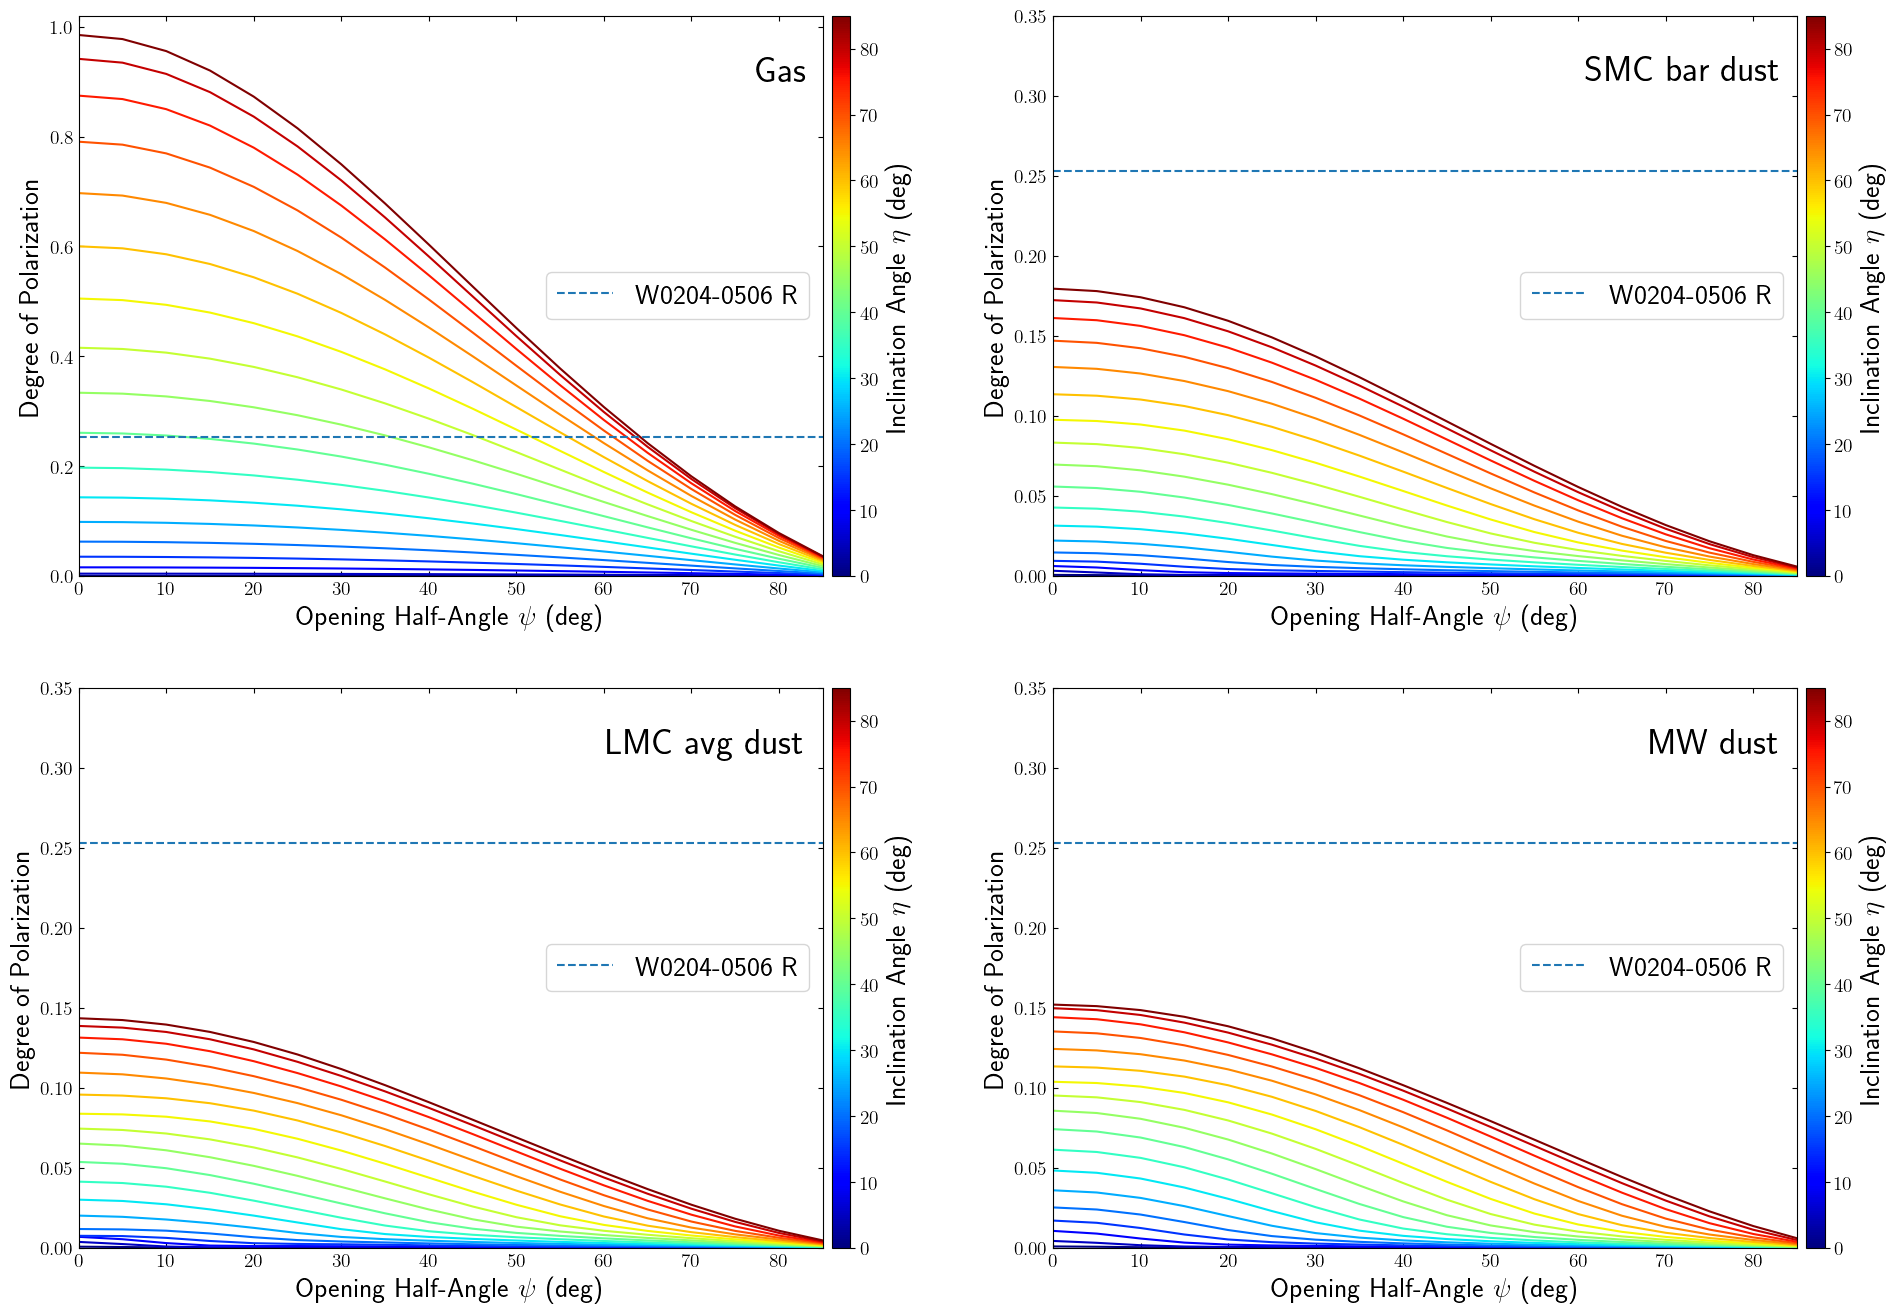

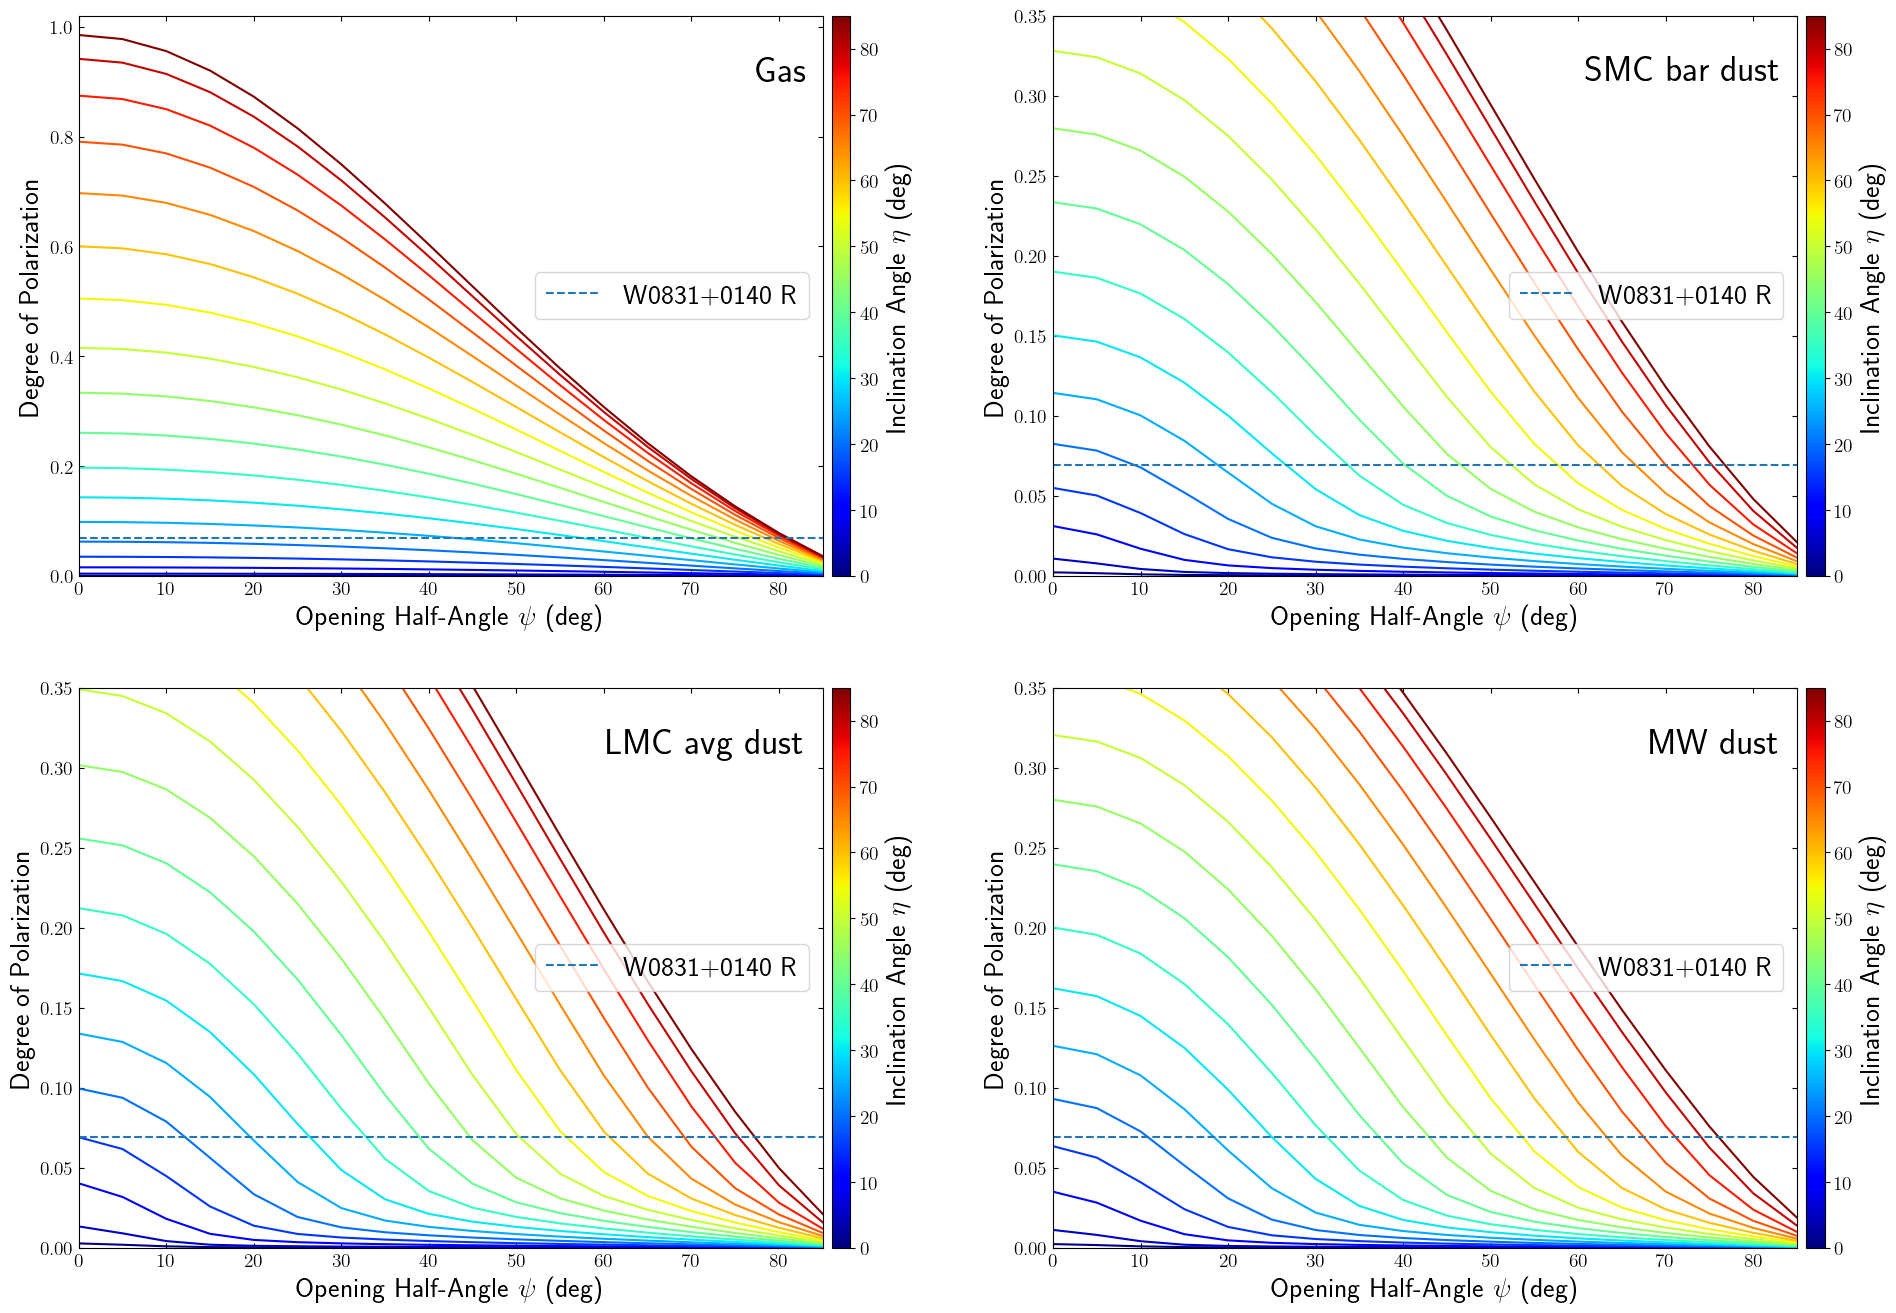

In [8]:
dust_models = ["gas", "SMC", "LMC", "MW"]
plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
fw = True
bw = True
suffix = "FWBW"
for wid in pol_data.keys():
    bands = load_bands(pol_data[wid]['bands'])
    spec = pol_data[wid]['spec']
    for iband, band_name in enumerate(pol_data[wid]["bands"]):
        fig, ax = plt.subplots(2,2,figsize=(24, 16))
        fig.subplots_adjust(wspace=0.1)
        plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
        ymax = [1.02, 0.35, 0.35, 0.35]
        for k, dust_model in enumerate(dust_models):
            p_bb = get_p_bb(dust_model, theta_angles, psi_angles, spec, [bands[iband]], fw=fw, bw=bw)
            plot_pol(p_bb[0], theta_angles, psi_angles, plot_fname=None, plot_label=plot_labels[k], ymax=ymax[k], fig=fig, ax=ax.flatten()[k])
            # #The detected polarization fraction. 
            # for key in pfrac.keys():
            puse = pol_data[wid]['pfrac'][iband]
            ax.flatten()[k].plot([0, 90], [puse, puse], '--', label=wid+" "+band_name)
            ax.flatten()[k].legend(loc=7, fontsize=20)
        plt.savefig("lowdens_combined_pol.{}.{}.{}.png".format(wid,band_name,suffix), dpi=100, bbox_inches='tight', transparent=False, facecolor='white')

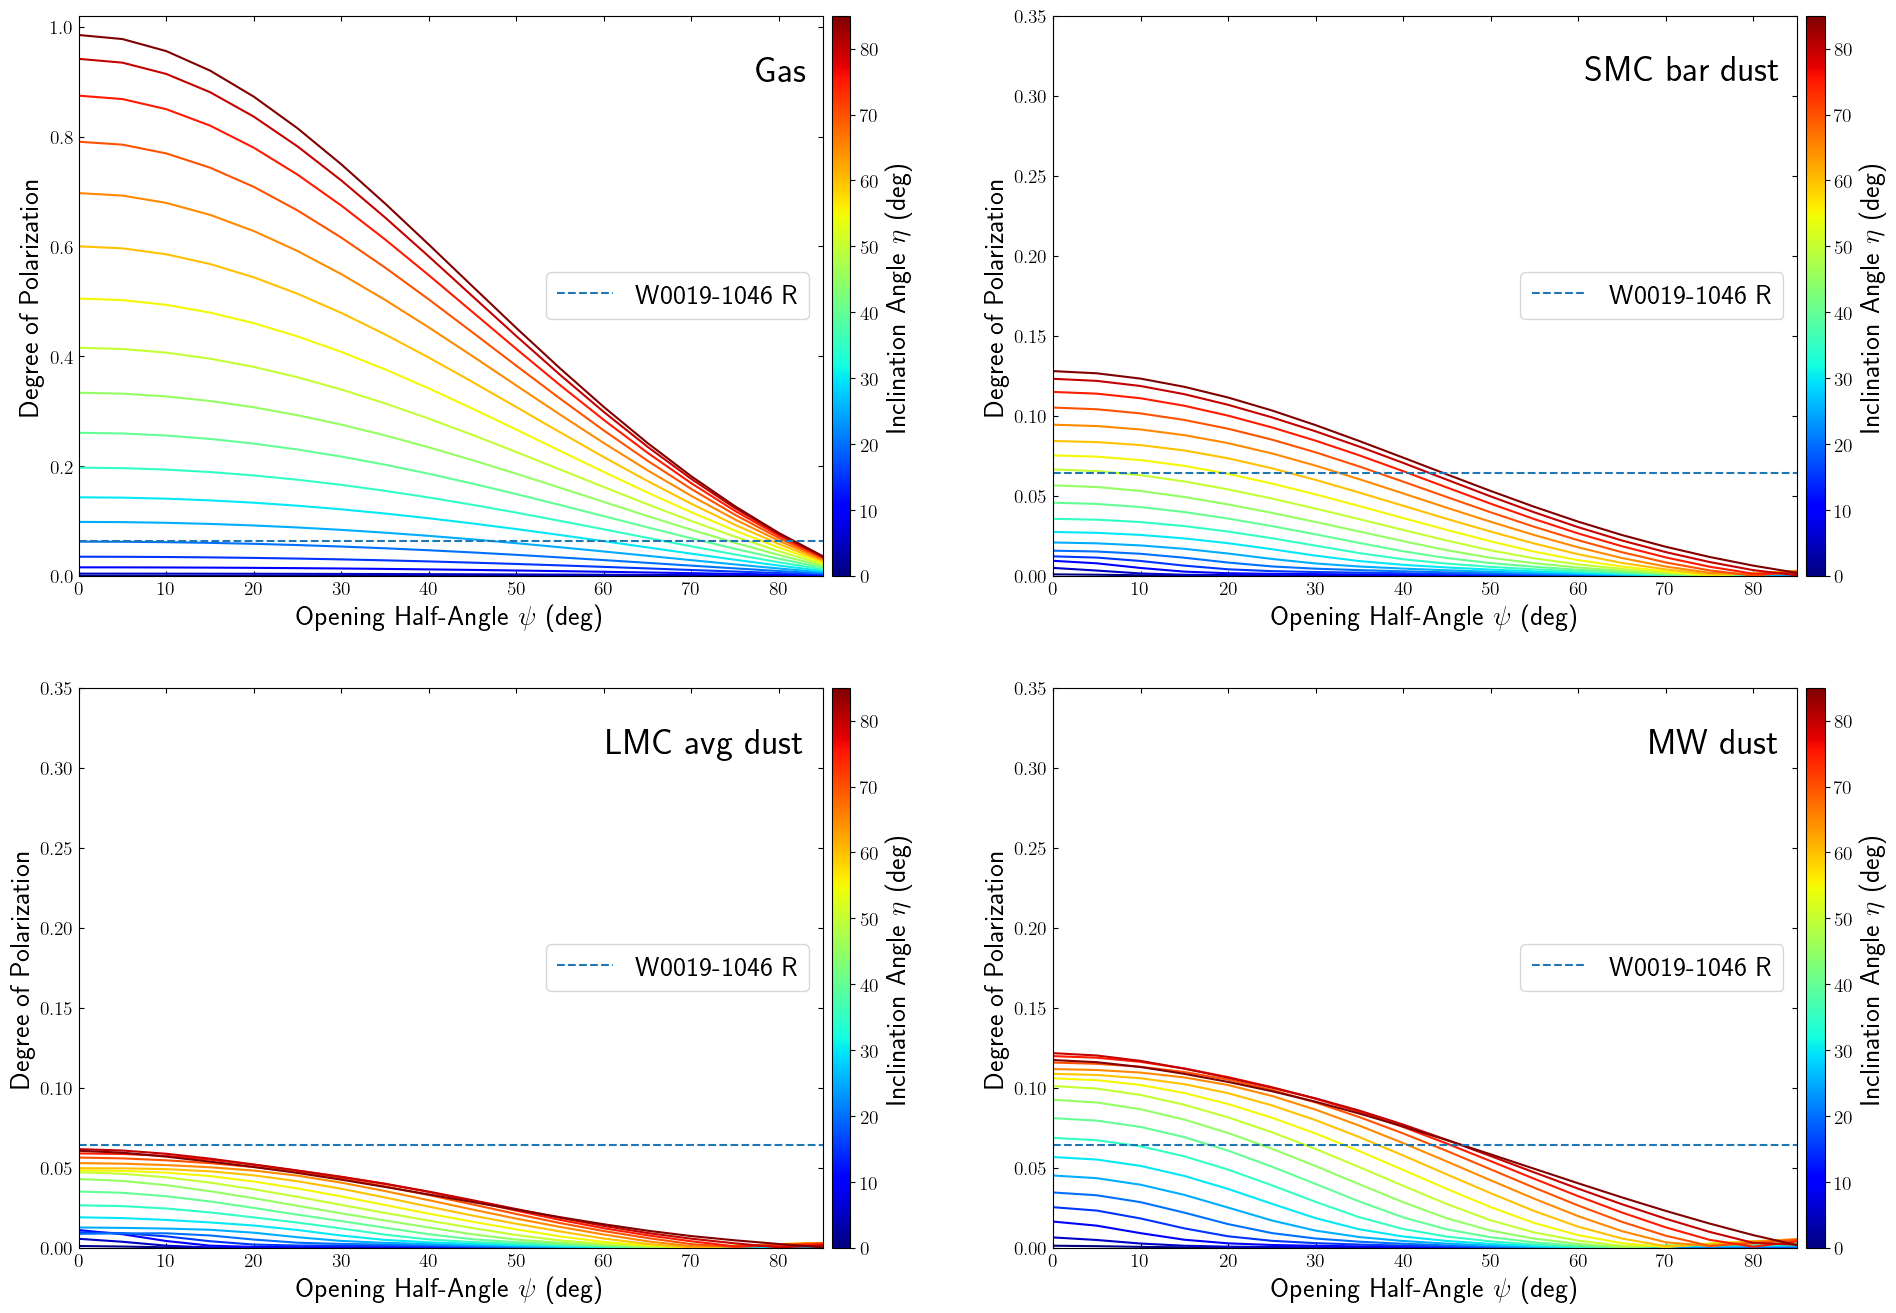

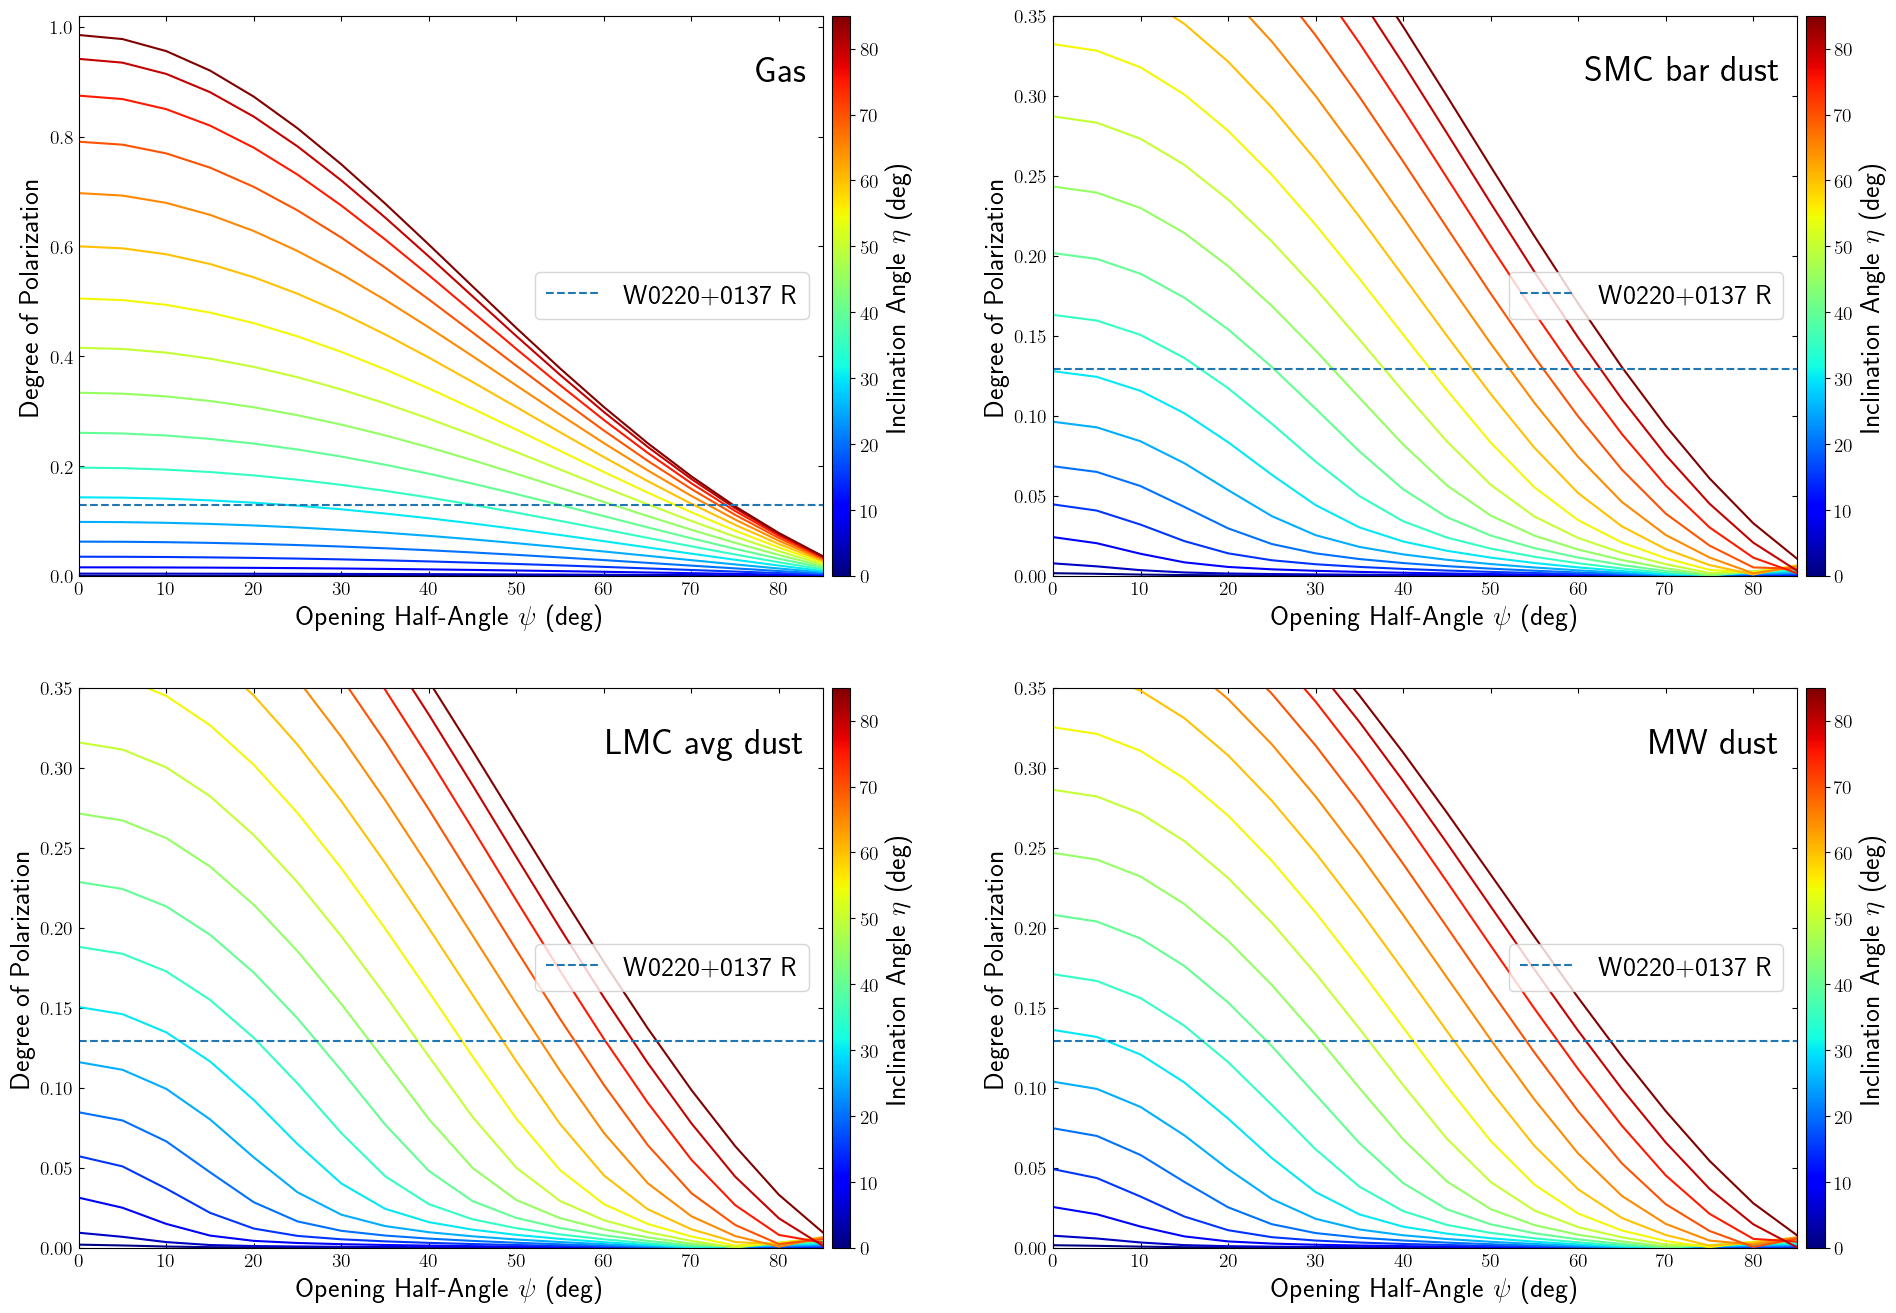

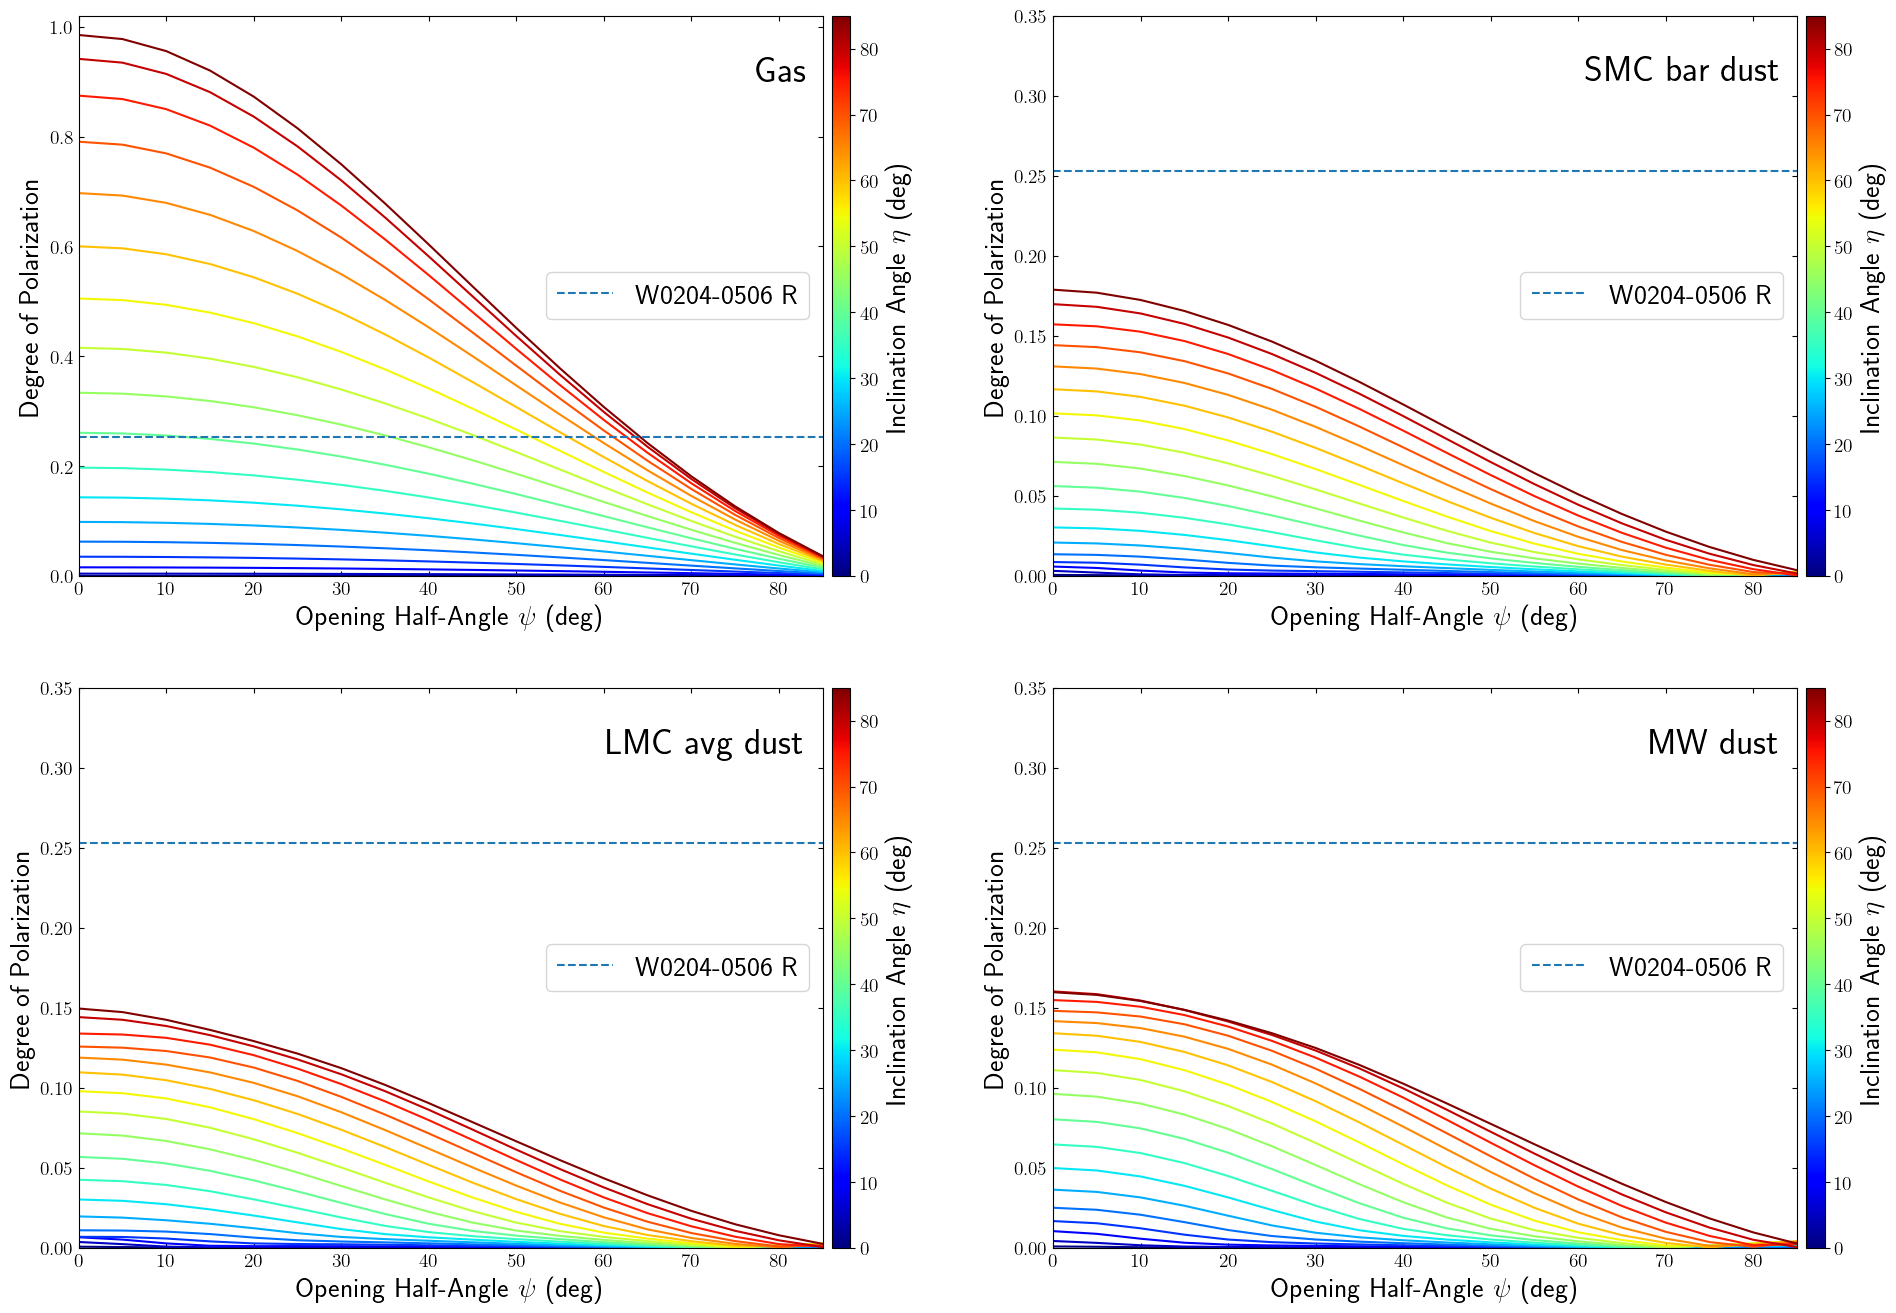

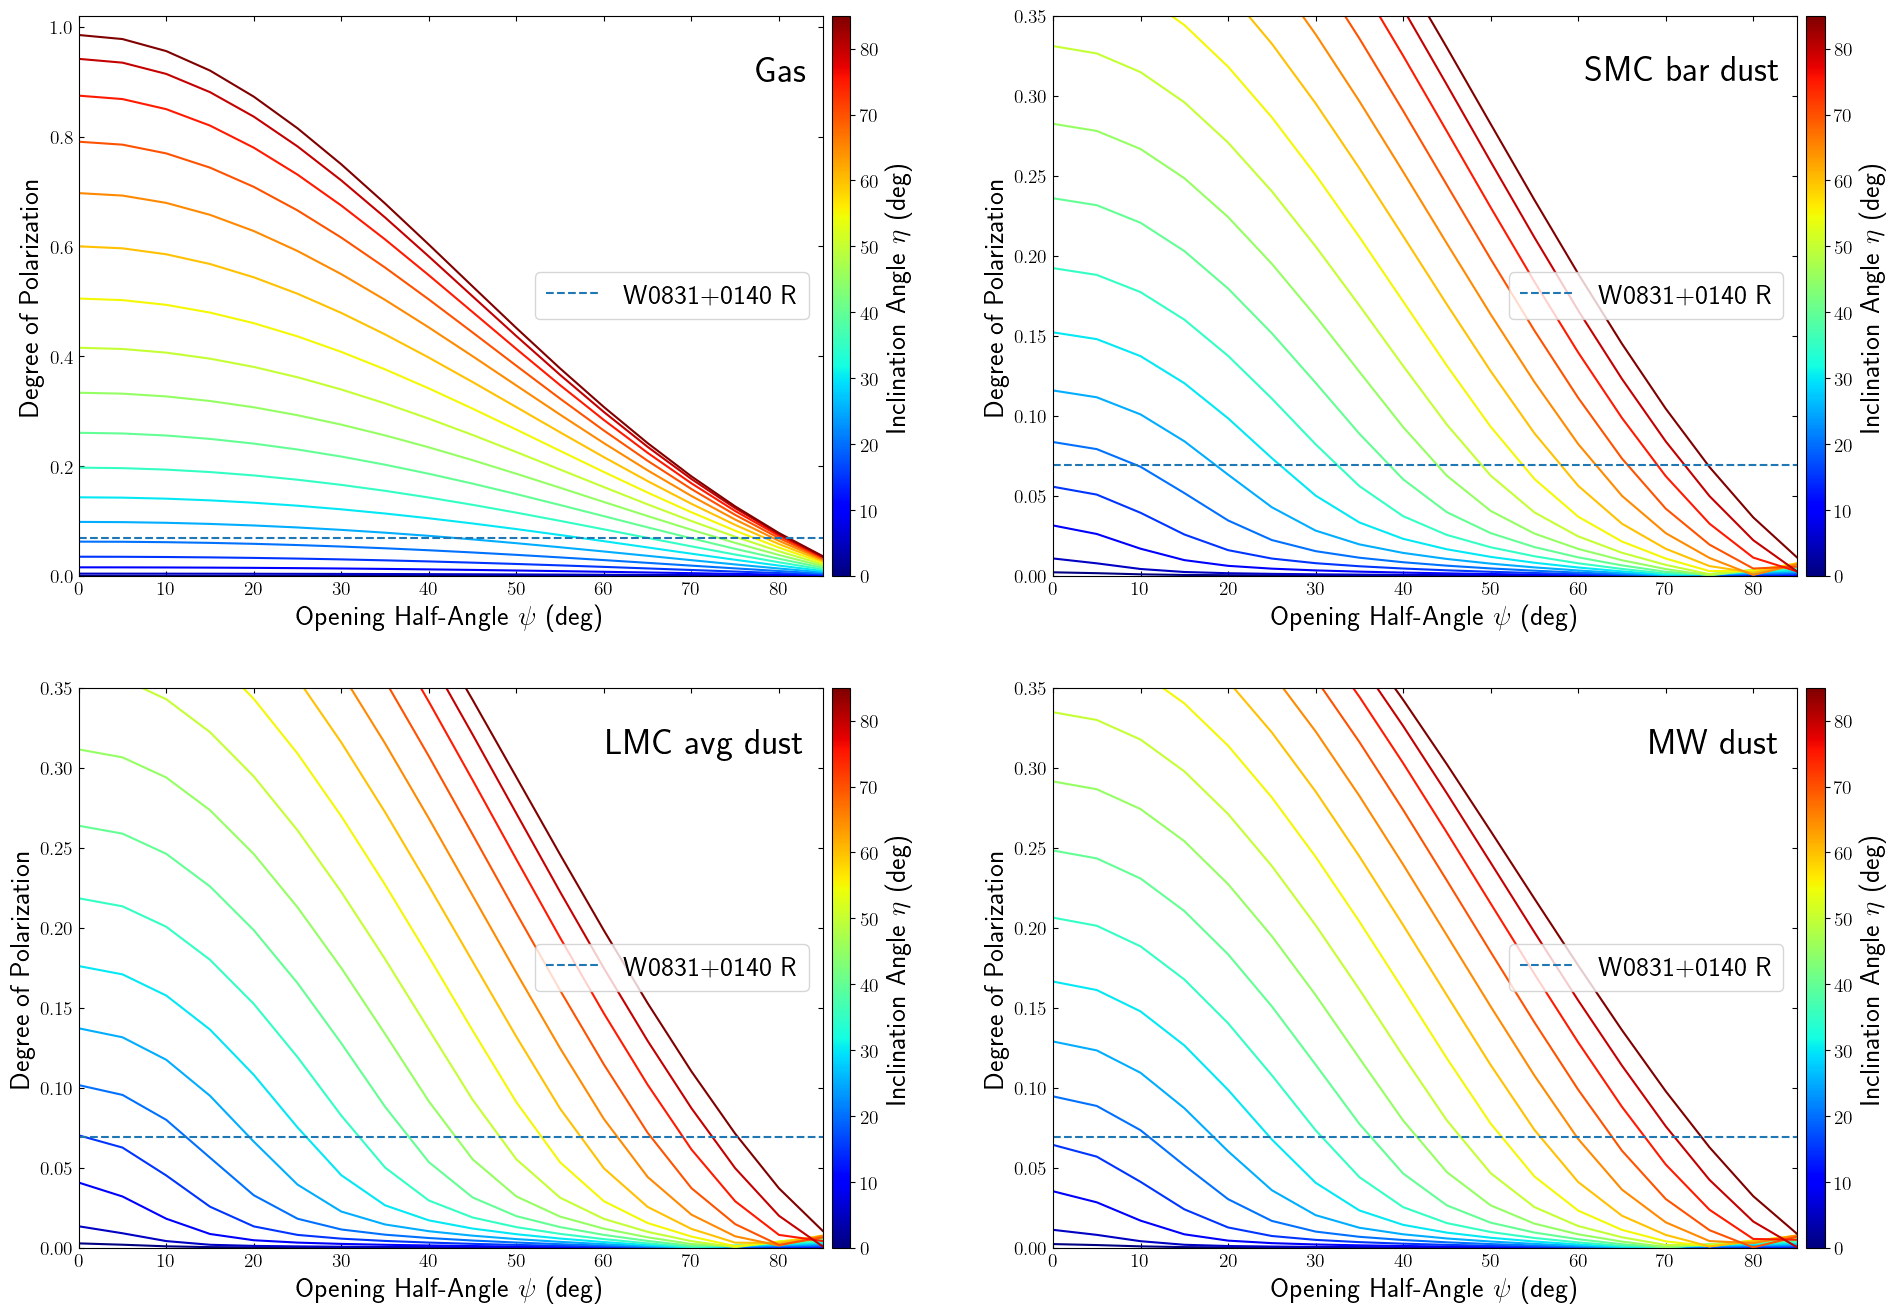

In [9]:
dust_models = ["gas", "SMC", "LMC", "MW"]
plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
fw = True
bw = False
suffix = "FW"
for wid in pol_data.keys():
    bands = load_bands(pol_data[wid]['bands'])
    spec = pol_data[wid]['spec']
    for iband, band_name in enumerate(pol_data[wid]["bands"]):
        fig, ax = plt.subplots(2,2,figsize=(24, 16))
        fig.subplots_adjust(wspace=0.1)
        plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
        ymax = [1.02, 0.35, 0.35, 0.35]
        for k, dust_model in enumerate(dust_models):
            p_bb = get_p_bb(dust_model, theta_angles, psi_angles, spec, [bands[iband]], fw=fw, bw=bw)
            plot_pol(p_bb[0], theta_angles, psi_angles, plot_fname=None, plot_label=plot_labels[k], ymax=ymax[k], fig=fig, ax=ax.flatten()[k])
            # #The detected polarization fraction. 
            # for key in pfrac.keys():
            puse = pol_data[wid]['pfrac'][iband]
            ax.flatten()[k].plot([0, 90], [puse, puse], '--', label=wid+" "+band_name)
            ax.flatten()[k].legend(loc=7, fontsize=20)
        plt.savefig("lowdens_combined_pol.{}.{}.{}.png".format(wid,band_name,suffix), dpi=100, bbox_inches='tight', transparent=False, facecolor='white')

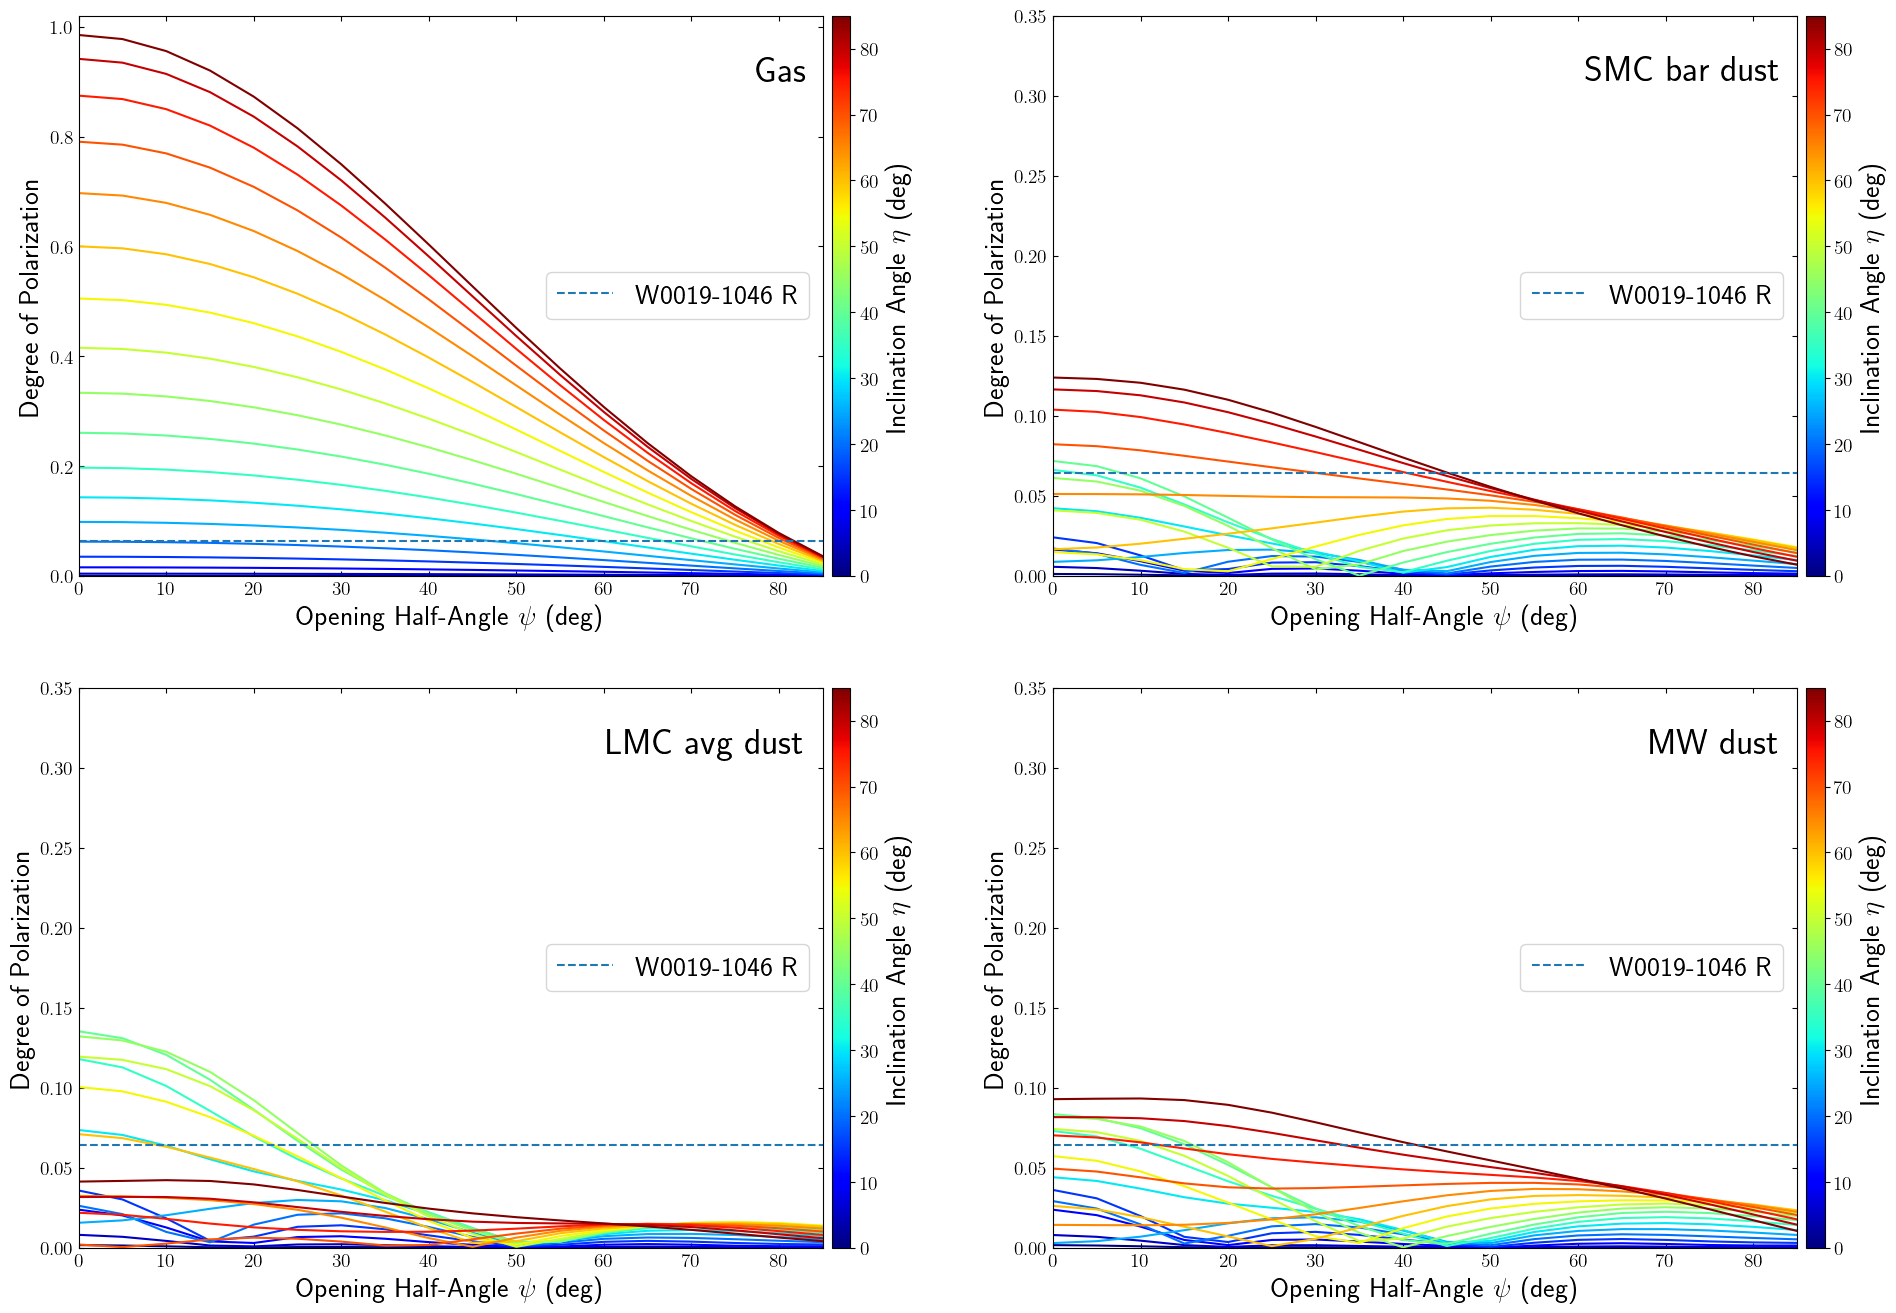

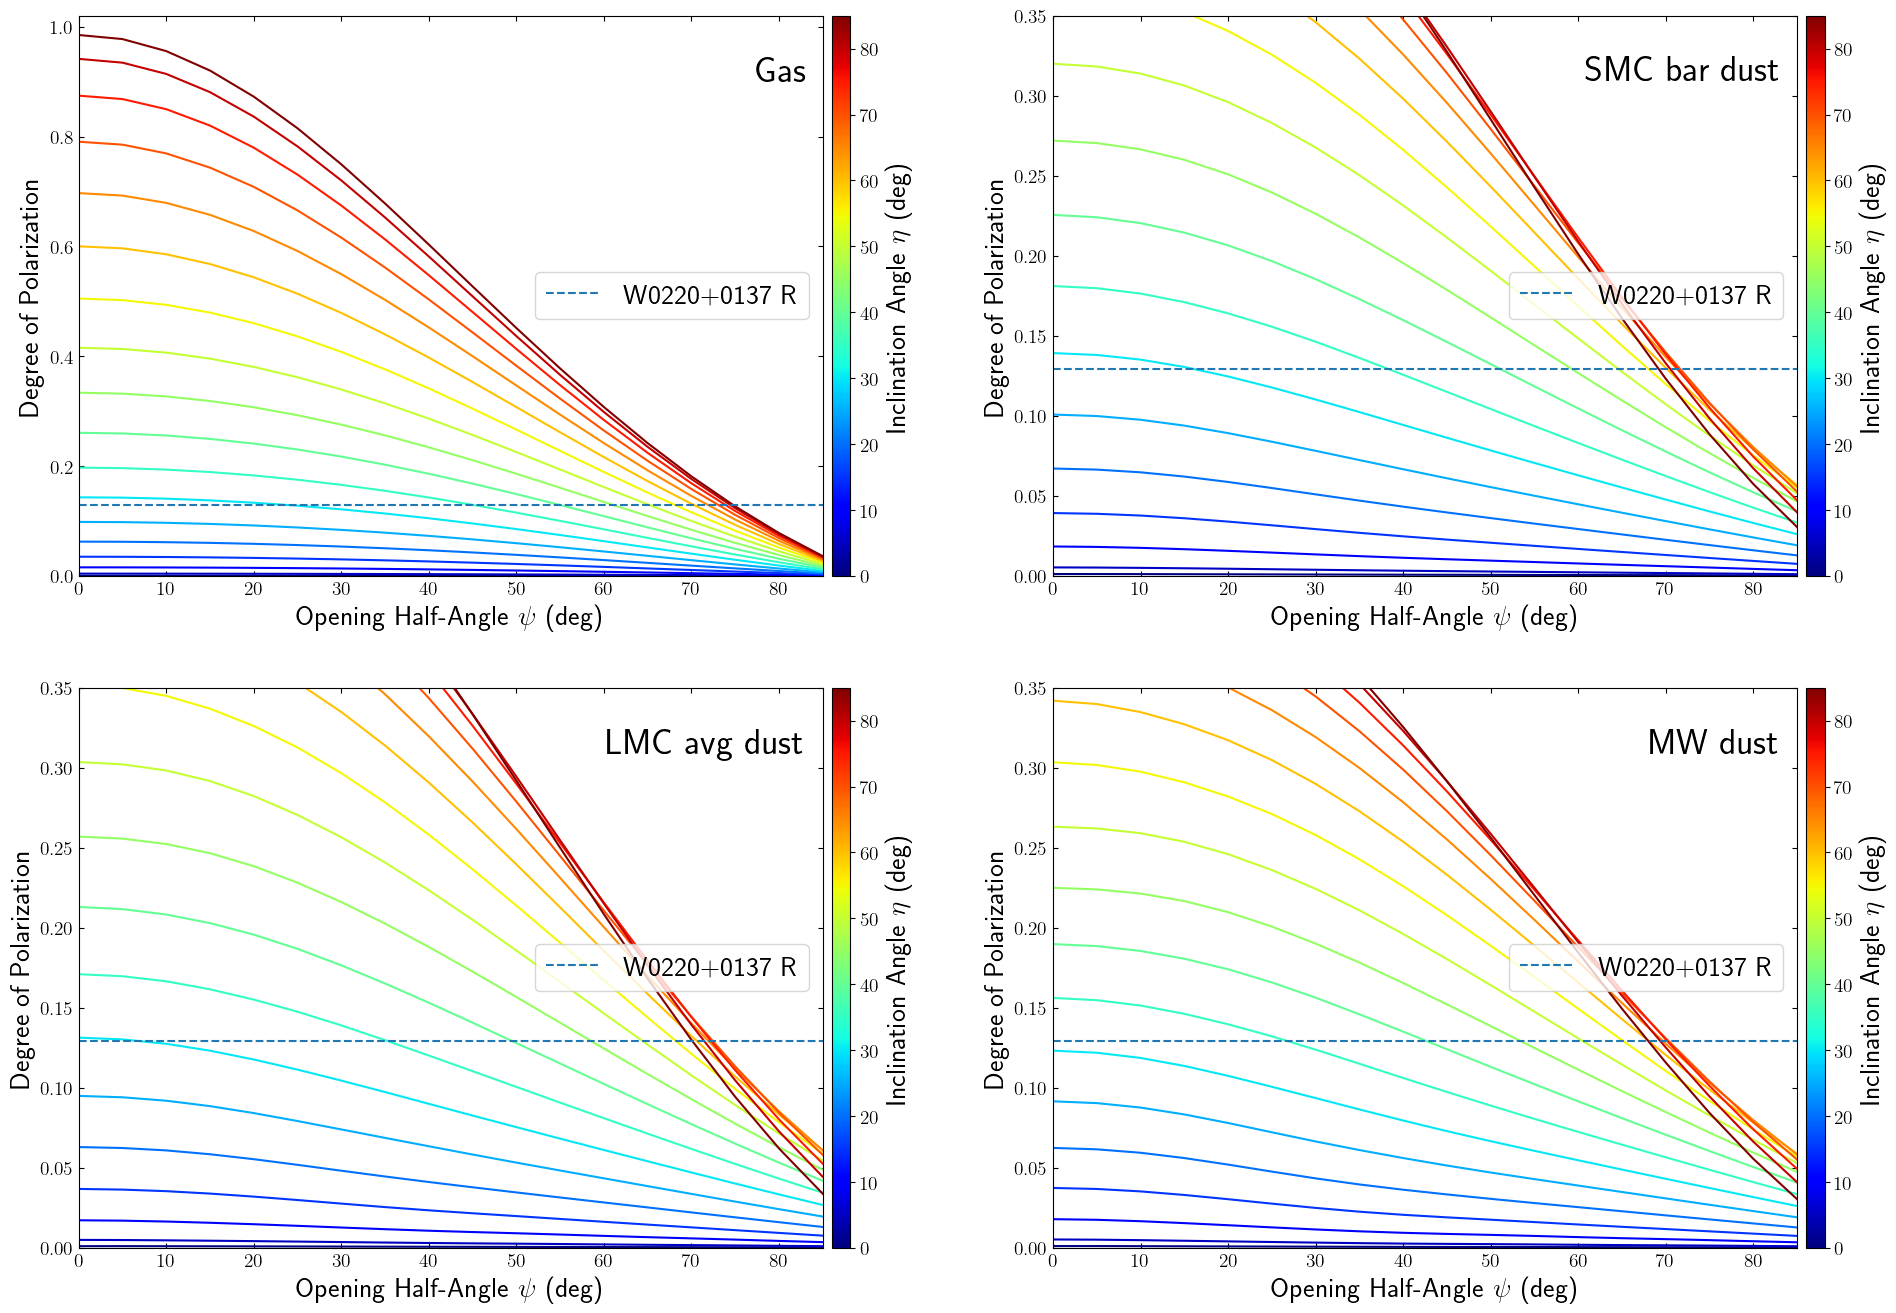

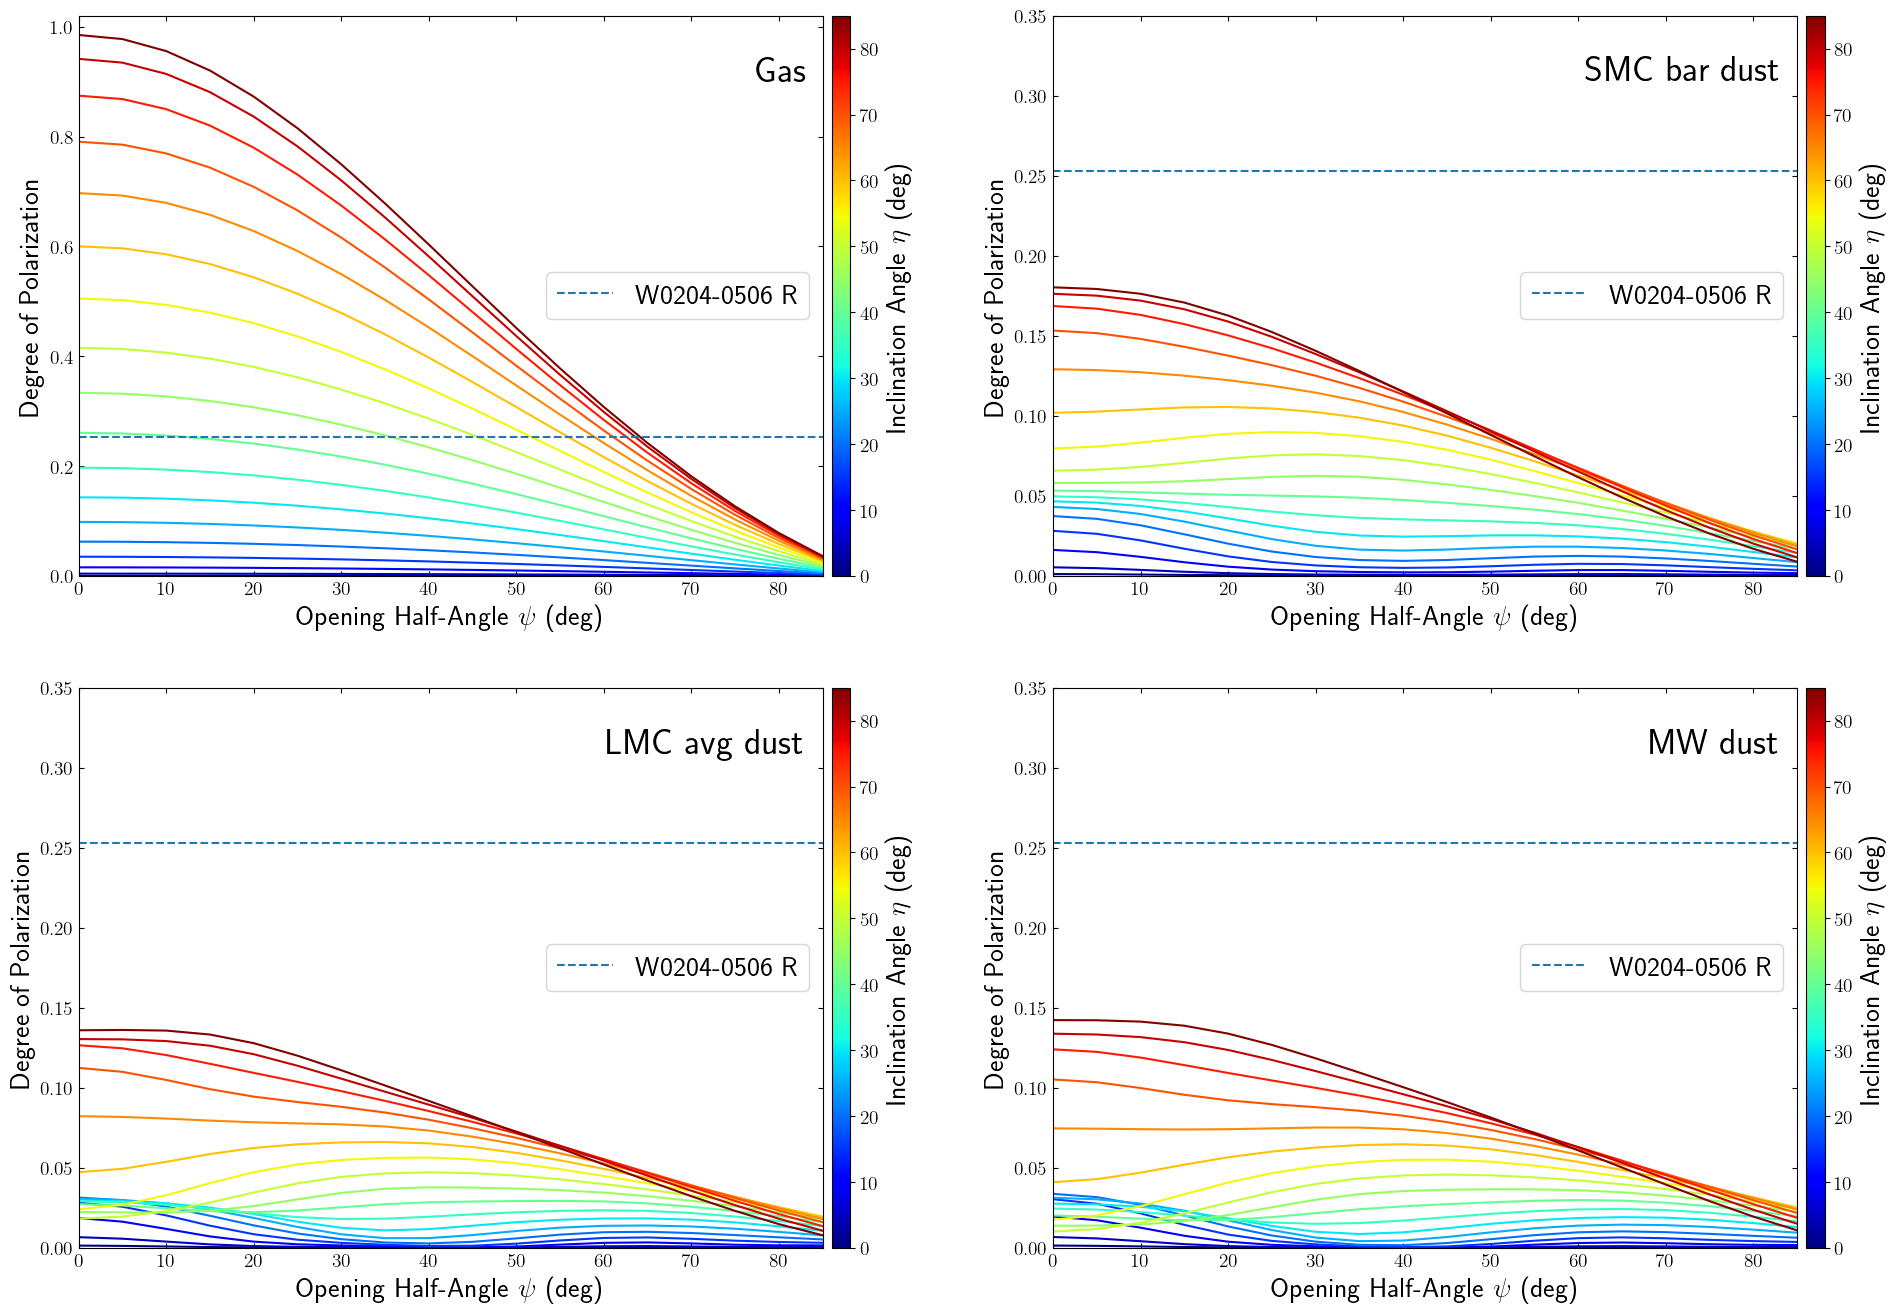

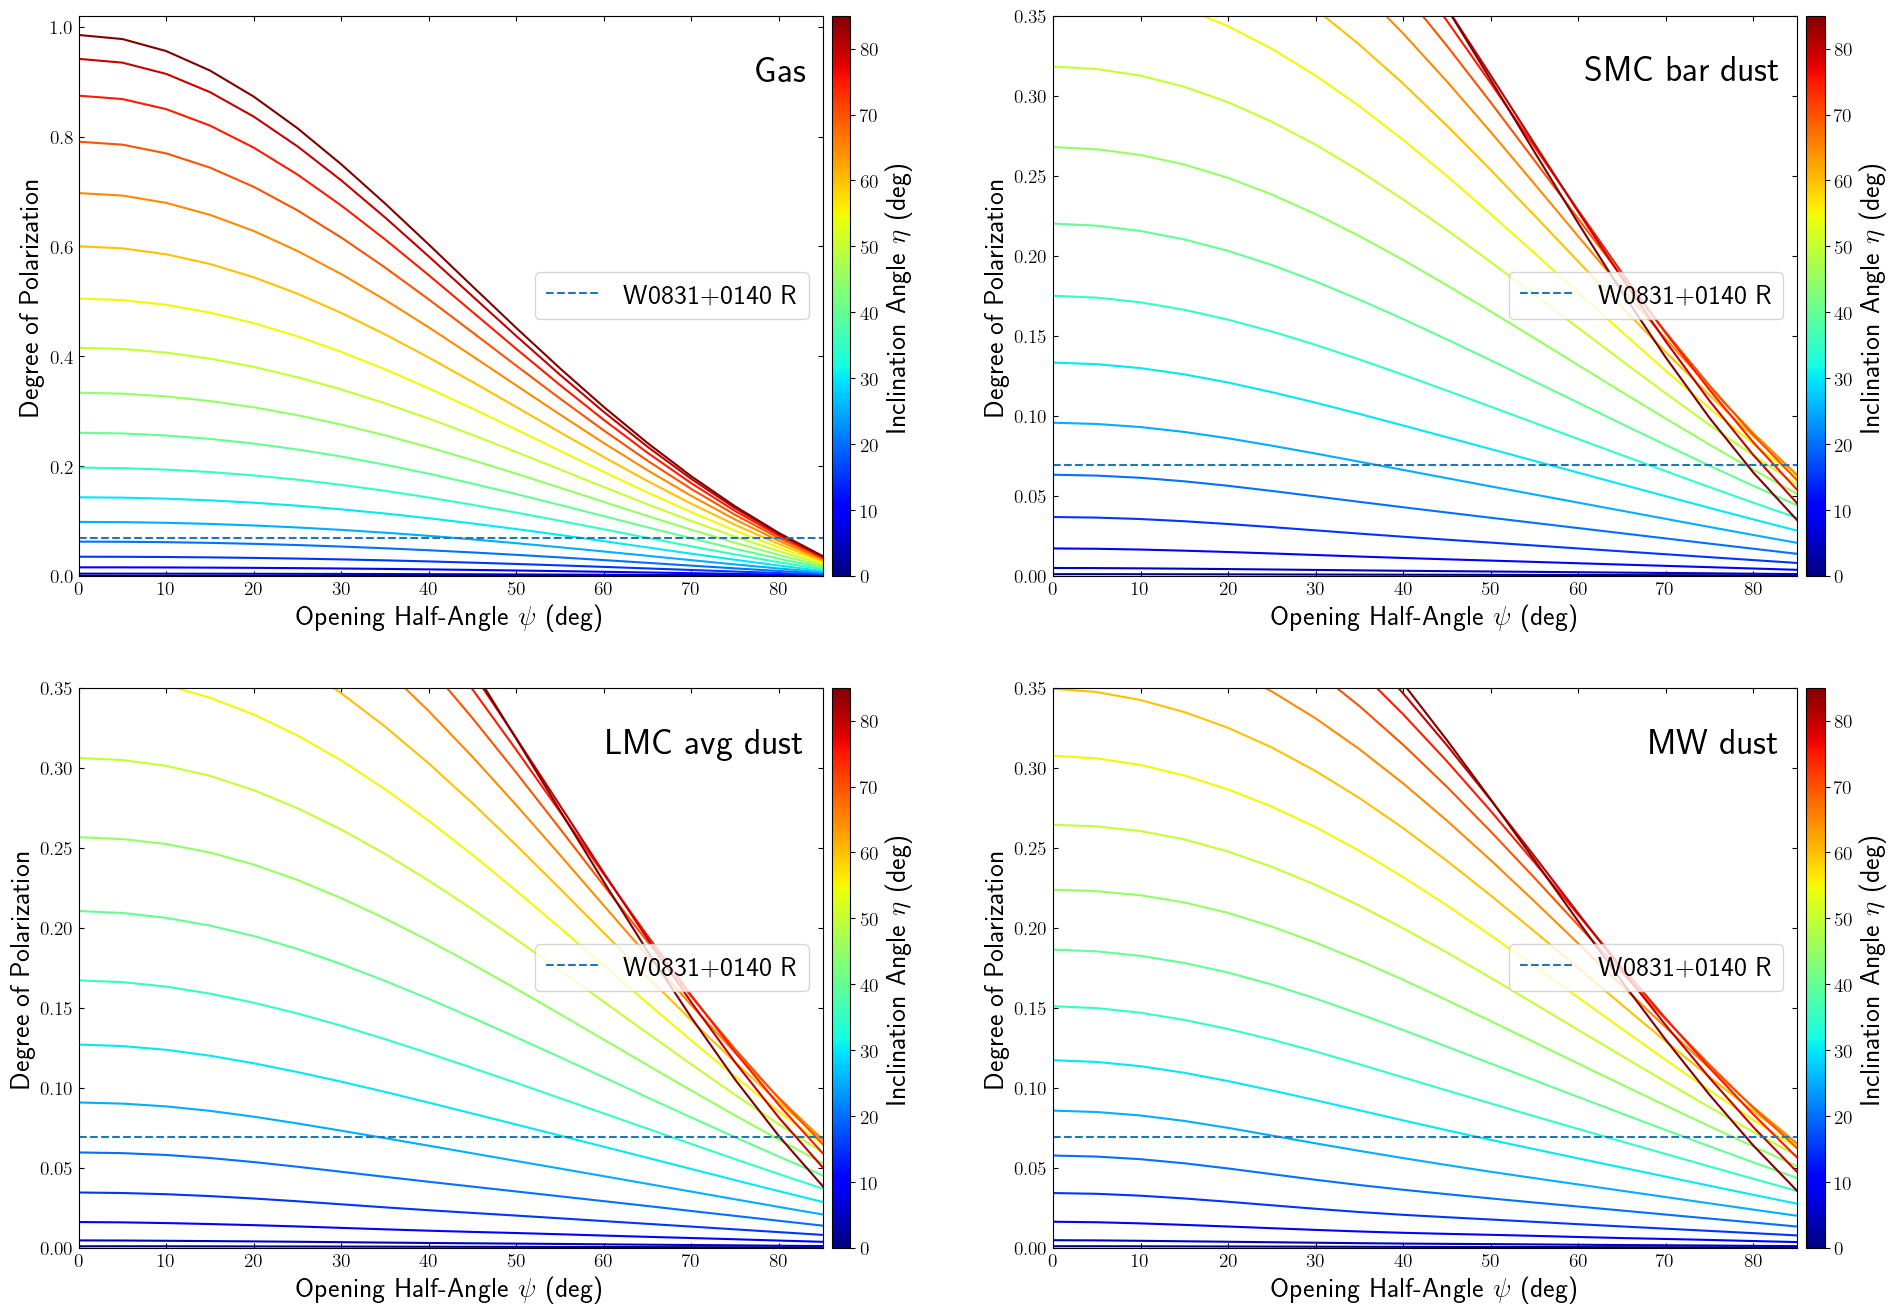

In [10]:
dust_models = ["gas", "SMC", "LMC", "MW"]
plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
fw = False
bw = True
suffix = "BW"
for wid in pol_data.keys():
    bands = load_bands(pol_data[wid]['bands'])
    spec = pol_data[wid]['spec']
    for iband, band_name in enumerate(pol_data[wid]["bands"]):
        fig, ax = plt.subplots(2,2,figsize=(24, 16))
        fig.subplots_adjust(wspace=0.1)
        plot_labels = ["Gas", "SMC bar dust", "LMC avg dust", "MW dust"]
        ymax = [1.02, 0.35, 0.35, 0.35]
        for k, dust_model in enumerate(dust_models):
            p_bb = get_p_bb(dust_model, theta_angles, psi_angles, spec, [bands[iband]], fw=fw, bw=bw)
            plot_pol(p_bb[0], theta_angles, psi_angles, plot_fname=None, plot_label=plot_labels[k], ymax=ymax[k], fig=fig, ax=ax.flatten()[k])
            # #The detected polarization fraction. 
            # for key in pfrac.keys():
            puse = pol_data[wid]['pfrac'][iband]
            ax.flatten()[k].plot([0, 90], [puse, puse], '--', label=wid+" "+band_name)
            ax.flatten()[k].legend(loc=7, fontsize=20)
        plt.savefig("lowdens_combined_pol.{}.{}.{}.png".format(wid,band_name,suffix), dpi=100, bbox_inches='tight', transparent=False, facecolor='white')